In [1]:
import os
import json

In [2]:
folder_path = "/Users/surajk/Work/JIT-performance-logs/data/gpt"

In [3]:
def load_json(file_path):
    with open(file_path, 'r') as f:
        try:
            d = json.load(f)    
        except ValueError as e:
            print(e)
    return d

In [4]:
traces = {'_'.join(file.split('_')[0:6]): load_json(os.path.join(folder_path,file)) for file in os.listdir(folder_path)}
print(traces.keys())

dict_keys(['gm__jit_gpt2_lm_inference', 'gm__jit_logreg_multi_epoch', 'gm__jit_bert_bert_base'])


In [28]:
def get_rt_agg_report(d):
    events = d["data"]["traceEvents"]
    start_ts = d["data"]["startTimestamp"]
    end_ts = d["data"]["endTimestamp"]
    prog_runtime = (end_ts - start_ts) * 1000
    
    print(f"Overall time: {prog_runtime}")
    
    overall_rt = {}
    overall_rt["RT_SETUP_AND_TEAR_DOWN"] = 0
    rt_idx = 0
    for e in events:
        if e['name'] == "runtime":
            if 'traceEvents' in e['args']:
                print(f"Runtime context {rt_idx} has {len(e['args']['traceEvents'])} events")
                jit_time = (e['ts']*1000 - start_ts*1000)
                print(f"Time spent (JIT): {jit_time} ns")
                rt_events = e['args']['traceEvents']

                # Hack we are ignoring the last event because its a metadata event.
                for idx in range(0, len(rt_events) - 1, 2):
                    assert (rt_events[idx]['name'] == rt_events[idx + 1]['name']) # Hack... but check
                    if (rt_events[idx]['name'] not in overall_rt):
                        overall_rt[rt_events[idx]['name']] = 0
                        
                    if rt_events[idx]['name'] not in context:
                        context[rt_events[idx]['name']] = 0
                        
                    dur = rt_events[idx + 1]['ts'] - rt_events[idx]['ts']

                    overall_rt[rt_events[idx]['name']] += dur
                    context[rt_events[idx]['name']] += dur
                    
                overall_rt["RT_SETUP_AND_TEAR_DOWN"] += jit_time - sum(context.values())

                rt_idx += 1
                print(f"Time spent (reported by snprof): {sum(context.values())} ns")
                print(context)
                print("===============================================")
            else:
                print("===============================================")
                print(f"Args: {e['args']}")
                start_ts = e["ts"]
                context = {}
        else:
            if e['name'] not in overall_rt:
                overall_rt[e['name']] = 0
                
            if e['ph'] is 'B':
                _start_ts = e['ts']
                
            if e['ph'] is 'E':
                overall_rt[e['name']] += (e['ts'] - _start_ts)*1000
                
    compile_time = overall_rt['compile']
    non_compile_time = prog_runtime - compile_time
    
    del overall_rt['compile']
     
    return {rt: overall_rt[rt]/non_compile_time * 100 for rt in overall_rt}

<>:49: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:52: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:49: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:52: SyntaxWarning: "is" with a literal. Did you mean "=="?
/var/folders/xz/lcpbmbm50wv44jth1r4tnx540000gp/T/ipykernel_62341/545304271.py:49: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if e['ph'] is 'B':
/var/folders/xz/lcpbmbm50wv44jth1r4tnx540000gp/T/ipykernel_62341/545304271.py:52: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if e['ph'] is 'E':


In [37]:
import matplotlib.pyplot as plt
def _bar_chart(data, title=""):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    langs = data.keys()
    students = data.values()
    ax.set(title="Runtime events performance (% of the non-compile time) - " + title)
    ax.bar(langs,students)
    plt.xticks(rotation=90)
    plt.show()

GPT2

In [38]:
gpt = get_rt_agg_report(traces['gm__jit_gpt2_lm_inference'])

Overall time: 96152071000
Args: {'tensor names': '[None, None, None, None, None]', 'tensor size': '{1, 1, 20, 12, 64}'}
Runtime context 0 has 51 events
Time spent (JIT): 559599000 ns
Time spent (reported by snprof): 40994.25 ns
{'FE_SET_TENSOR': 13412.75, 'RT_SET_TENSORS': 13405.5, 'SN_CONV_FUNC_CB': 2102.5, 'FE_LAUNCH_SESSION': 3015.75, 'RT_SESS_LAUNCH': 3012.5, 'SN_FSM_SETUP': 4.5, 'SN_FSM_SECTION': 2944.75, 'SAL_PROG_LOAD_HW': 66.0, 'SAL_RUN_PROG_HW': 2806.0, 'SN_FSM_TEARDOWN': 1.25, 'FE_GET_TENSOR': 111.0, 'RT_GET_TENSORS': 101.0, 'BUF_XFER_MEMCPY_EXEC': 10.75}
Args: {'tensor names': '[None, None, None, None]', 'tensor size': '{1, 20, 12, 12}'}
Runtime context 1 has 37 events
Time spent (JIT): 580711000 ns
Time spent (reported by snprof): 61019.25 ns
{'FE_SET_TENSOR': 100.75, 'RT_SET_TENSORS': 94.0, 'SN_CONV_FUNC_CB': 67.25, 'FE_LAUNCH_SESSION': 153.5, 'RT_SESS_LAUNCH': 151.0, 'SN_FSM_SETUP': 3.0, 'SN_FSM_SECTION': 136.0, 'SAL_PROG_LOAD_HW': 35.5, 'SAL_RUN_PROG_HW': 68.75, 'SN_FSM_

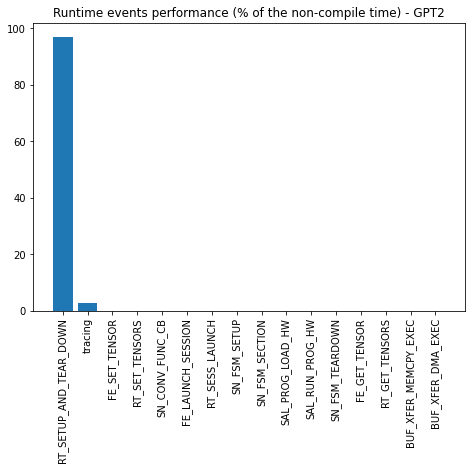

In [39]:
_bar_chart(gpt, "GPT2")

Logreg - 100 epochs

In [40]:
logreg = get_rt_agg_report(traces['gm__jit_logreg_multi_epoch'])

Overall time: 94707990000
Args: {'tensor names': '[None, None]', 'tensor size': '{1, 2}'}
Runtime context 0 has 31 events
Time spent (JIT): 420468000 ns
Time spent (reported by snprof): 519.0 ns
{'FE_SET_TENSOR': 66.5, 'RT_SET_TENSORS': 61.5, 'SN_CONV_FUNC_CB': 40.25, 'FE_LAUNCH_SESSION': 104.0, 'RT_SESS_LAUNCH': 101.5, 'SN_FSM_SETUP': 2.75, 'SN_FSM_SECTION': 73.25, 'SAL_PROG_LOAD_HW': 33.25, 'SAL_RUN_PROG_HW': 11.75, 'SN_FSM_TEARDOWN': 0.5, 'FE_GET_TENSOR': 12.75, 'RT_GET_TENSORS': 11.0}
Args: {'tensor names': '[None, None]', 'tensor size': '{2, 16}'}
Runtime context 1 has 35 events
Time spent (JIT): 420620000 ns
Time spent (reported by snprof): 422.75 ns
{'FE_SET_TENSOR': 38.5, 'RT_SET_TENSORS': 31.75, 'SN_CONV_FUNC_CB': 6.5, 'FE_LAUNCH_SESSION': 98.0, 'RT_SESS_LAUNCH': 95.25, 'SN_FSM_SETUP': 3.25, 'SN_FSM_SECTION': 83.25, 'SAL_PROG_LOAD_HW': 37.0, 'SAL_RUN_PROG_HW': 12.25, 'SN_FSM_TEARDOWN': 0.75, 'FE_GET_TENSOR': 9.25, 'RT_GET_TENSORS': 7.0}
Args: {'tensor names': '[None, None]', '

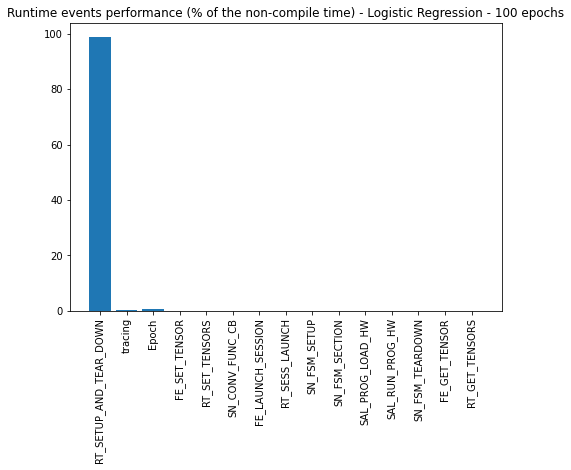

In [41]:
_bar_chart(logreg, 'Logistic Regression - 100 epochs')

In [42]:
bert = get_rt_agg_report(traces['gm__jit_bert_bert_base'])

Overall time: 282560659000
Args: {'tensor names': '[None, None, None]', 'tensor size': '{1, 16, 30522}'}
Runtime context 0 has 1017 events
Time spent (JIT): 664371000 ns
Time spent (reported by snprof): 674772.25 ns
{'FE_SET_TENSOR': 96722.5, 'RT_SET_TENSORS': 96658.5, 'SN_CONV_FUNC_CB': 98913.5, 'FE_LAUNCH_SESSION': 77457.5, 'RT_SESS_LAUNCH': 77455.25, 'SN_FSM_SETUP': 6.0, 'SN_FSM_SECTION': 77330.75, 'SAL_PROG_LOAD_HW': 298.25, 'SAL_RUN_PROG_HW': 76741.5, 'SN_FSM_TEARDOWN': 1.25, 'FE_GET_TENSOR': 24088.75, 'RT_GET_TENSORS': 23950.25, 'BUF_XFER_MEMCPY_EXEC': 24769.75, 'BUF_XFER_DMA_EXEC': 378.5}


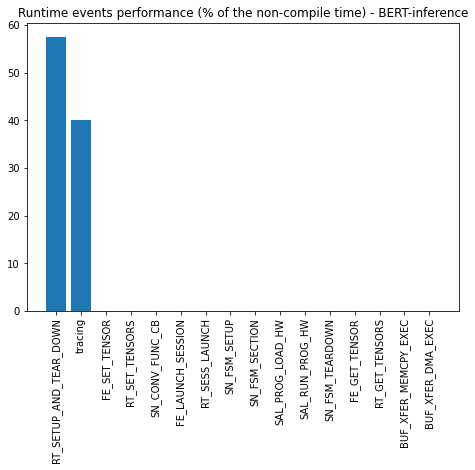

In [43]:
_bar_chart(bert, 'BERT-inference')